# Exeriment 3
* Performance comparation between LSTM, CNN, and Classical Machine Learning Model
* Input data: [Case 1] and [Case 2] in Experiment 1 (preprocess.ipynb) and Experiment 2 (LSTM_EHA.ipynb)

In [1]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
# from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
# from keras.layers import Attention
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import mlxtend
from mlxtend.plotting import plot_decision_regions

import seaborn as sns


%matplotlib inline
# %matplotlib notebook

# 1. Load dataset and data preparation

In [3]:
# Selected features: 
with open('daisee_openface/daisee_EHA.pkl','rb') as f:
    X_train_eye, X_val_eye, X_test_eye, X_train_head, X_val_head, X_test_head, X_train_au, X_val_au, X_test_au, Y_train_eye, Y_val_eye,  Y_test_eye= pickle.load(f)

# stack all features
X_train = np.dstack((X_train_eye,X_train_head,X_train_au))
X_val = np.dstack((X_val_eye,X_val_head,X_val_au))
X_test = np.dstack ((X_test_eye,X_test_head,X_test_au))
print(X_train.shape,X_val.shape,X_test.shape)

#modify label for dataset [case 2]
def modif_label(Y):
    Y = np.where(Y==1, 0, Y) #combine label 0 and 1
    Y = np.where(Y==2, 1, Y) #change label 2 to 1
    Y = np.where(Y==3, 2, Y) #change label 3 to 2
    print('Y before encode =', Y)
    # print('Shape before encode =', Y.shape)
    Y = LabelEncoder().fit_transform(Y) #encode label value as label variable
    print('Y after encode =', Y)
    print('Shape after encode =', Y.shape)
    return Y

(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)


In [4]:
# Modify and split label
# [Case 2]
Y_train = Y_train_eye
Y_train_modif = modif_label(Y_train)
Y_val = Y_val_eye
Y_val_modif = modif_label(Y_val)
Y_test = Y_test_eye
Y_test_modif = modif_label(Y_test)
print('Y train',Y_train_modif)

Y before encode = [1 1 2 ... 0 2 2]
Y after encode = [1 1 2 ... 0 2 2]
Shape after encode = (5467,)
Y before encode = [1 2 1 ... 1 2 1]
Y after encode = [1 2 1 ... 1 2 1]
Shape after encode = (1703,)
Y before encode = [1 1 1 ... 2 2 1]
Y after encode = [1 1 1 ... 2 2 1]
Shape after encode = (1782,)
Y train [1 1 2 ... 0 2 2]


In [5]:
# Scalling for selected features input
tic = datetime.now()

scaler = MinMaxScaler(feature_range=(0,1))
X_train_scalled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_val_scalled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scalled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

time = datetime.now() - tic
print('Processing time {}'.format(time))
print(X_train_scalled.shape,X_val_scalled.shape,X_test_scalled.shape)

Processing time 0:00:00.015999
(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)


In [6]:
Y_train_cat = to_categorical(Y_train_modif)
Y_val_cat = to_categorical(Y_val_modif)
Y_test_cat = to_categorical(Y_test_modif)
print('Y train',Y_train_cat.shape)

Y train (5467, 3)


# 2. Model

In [11]:
X_train_concat = np.concatenate([X_train,X_val], axis=0)

number_of_train = X_train_concat.shape[0]
number_of_test = X_test.shape[0]
print(X_train_concat.shape, X_test.shape, number_of_train, number_of_test)

(7170, 10, 23) (1782, 10, 23) 7170 1782


In [17]:
# Converting input to 2D matrix
X_train_flatten = X_train.reshape(X_train_concat.shape[0],(X_train_concat.shape[1]*X_train_concat.shape[2]))
# X_train_flatten = X_train.reshape(X_train.reshape(-1, X_train.shape[-1]))
# X_test_flatten = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])
print(X_train_flatten.shape)

ValueError: cannot reshape array of size 1257410 into shape (7170,230)

In [12]:
# CNN
def CNN(X):
    # Initialising the CNN
    model = Sequential()

    ## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
    # 1 - Convolution
    model.add(Conv1D(64,3, padding='same', input_shape=((X.shape[1],X.shape[2]))))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2)) #downsampling/ shrink the height and width dimension by factor of 2  
   
    # 2nd Convolution layer
    model.add(Conv1D(128,5, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # 3rd Convolution layer
    model.add(Conv1D(512,3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # 4th Convolution layer
    model.add(Conv1D(512,3, padding='same'))#
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    # Fully connected layer 3nd layer
    model.add(Dense(512, name = 'convy'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(3, activation='softmax'))

    model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001)
    model._name='CNNmodel'
    model.summary()

    return model

In [13]:
# LSTM
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model._name='vanilaLSTM'
    print(model.summary())
    return model

def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='stackedLSTM'
    print(model.summary())
    return model

def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM'
    print(model.summary())
    return model

def biLSTM_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.2))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM_en'
    print(model.summary())
    return model

### Instantiate the model

In [14]:
# CNN
CNN_model = CNN(X_train)

# LSTM
vanilaLSTM_model = vanilaLSTM(X_train) # Selected feature input
stackedLSTM_model = stackedLSTM(X_train)
biLSTM_model = biLSTM(X_train)
biLSTM_en_model = biLSTM_en(X_train)

Model: "CNNmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 10, 64)            4480      
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 64)            256       
_________________________________________________________________
activation_8 (Activation)    (None, 10, 64)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 128)            41088     
_________________________________________________________________
activation_9 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 128)            512

# Compile, fit, and evaluate the model

In [15]:
def compile_train(model,Xtrain,Ytrain,Xval,Yval):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy',tf.keras.metrics.AUC()]) #

    filepath = 'weights/' + model.name + '_EHA.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    
    # reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001,mode='auto')
    es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50)
    history = model.fit(Xtrain,Ytrain, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],
                        batch_size = 32,
                        # validation_split=0.2
                        validation_data = (Xval,Yval), 
                        shuffle=False,
                        class_weight = 'balanced'
                       )

    weight_file = model.save(filepath) 
    return history


def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='macro')
    fbeta = fbeta_score(Ytest, pred, average='macro', beta=4)
    auc = roc_auc_score(Ytest, trainedmodel.predict_proba(Xtest), average='macro', multi_class='ovr')
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error,
        '\n MSE = ',mse,
        '\n Accuracy = ',acc,
        '\n AUC = ', auc,
        '\n F1-score = ',f1,
        '\n Fbeta = ',fbeta
        )

    #  Plotting confusion matrix
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    cm = pd.DataFrame(cm,range(3),range(3))

    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    return 

## Train and compile
### CNN
Selected features (non-scalled)

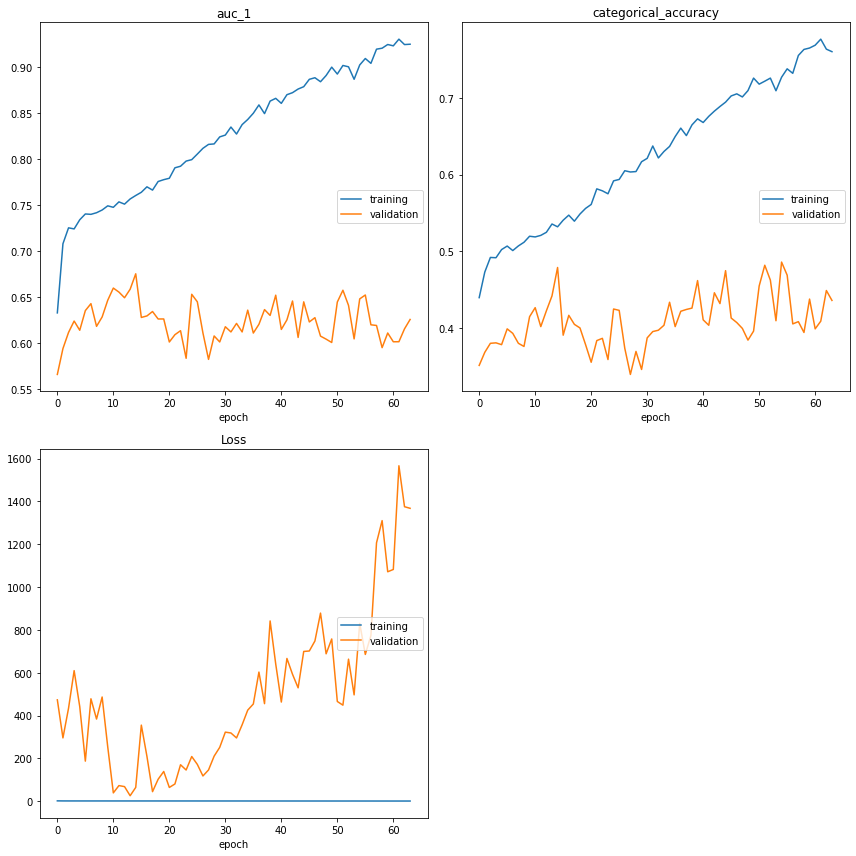

auc_1
	training         	 (min:    0.633, max:    0.931, cur:    0.925)
	validation       	 (min:    0.566, max:    0.675, cur:    0.626)
categorical_accuracy
	training         	 (min:    0.440, max:    0.776, cur:    0.760)
	validation       	 (min:    0.340, max:    0.486, cur:    0.436)
Loss
	training         	 (min:    0.481, max:    1.283, cur:    0.501)
	validation       	 (min:   25.269, max: 1566.792, cur: 1368.047)
5467/5467 [==============================] - 2s 304us/sample - loss: 0.5007 - categorical_accuracy: 0.7600 - auc_1: 0.9252 - val_loss: 1368.0474 - val_categorical_accuracy: 0.4363 - val_auc_1: 0.6258
Training time:0:01:44.600505
1782/1782 [==============================] - 0s 114us/sample - loss: 3.5684 - categorical_accuracy: 0.4697 - auc_1: 0.6645
Accuracy on Test set: 46.97%
|CNNmodel|
 Error rate = 0.5303030303030303 
 MSE =  0.6111111111111112 
 Accuracy =  0.4696969696969697 
 AUC =  0.5459536292856074 
 F1-score =  0.3198436387690931 
 Fbeta =  0.337643434764

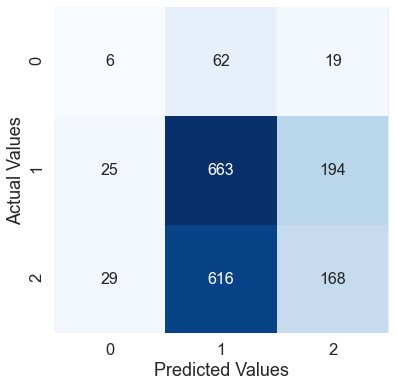

In [16]:
tic = datetime.now()

compile_train(CNN_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = CNN_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(CNN_model,X_test, Y_test_modif))

Selected features (scalled)

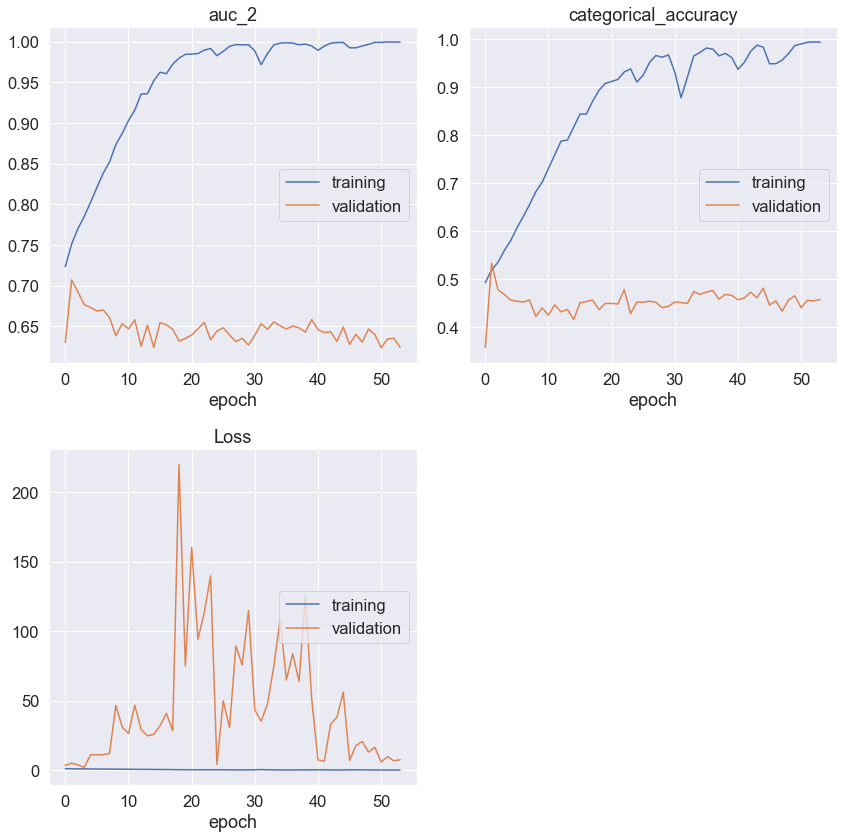

auc_2
	training         	 (min:    0.723, max:    1.000, cur:    1.000)
	validation       	 (min:    0.624, max:    0.707, cur:    0.624)
categorical_accuracy
	training         	 (min:    0.493, max:    0.994, cur:    0.994)
	validation       	 (min:    0.358, max:    0.533, cur:    0.458)
Loss
	training         	 (min:    0.020, max:    0.995, cur:    0.023)
	validation       	 (min:    1.886, max:  220.075, cur:    7.397)
5467/5467 [==============================] - 2s 321us/sample - loss: 0.0231 - categorical_accuracy: 0.9936 - auc_2: 0.9996 - val_loss: 7.3968 - val_categorical_accuracy: 0.4580 - val_auc_2: 0.6240
Training time:0:01:34.536673
1782/1782 [==============================] - 0s 87us/sample - loss: 5.4450 - categorical_accuracy: 0.4731 - auc_2: 0.6589
Accuracy on Test set: 47.31%
|CNNmodel|
 Error rate = 0.5269360269360269 
 MSE =  0.6178451178451179 
 Accuracy =  0.4730639730639731 
 AUC =  0.5408288169546579 
 F1-score =  0.36895296180604453 
 Fbeta =  0.363257676302994

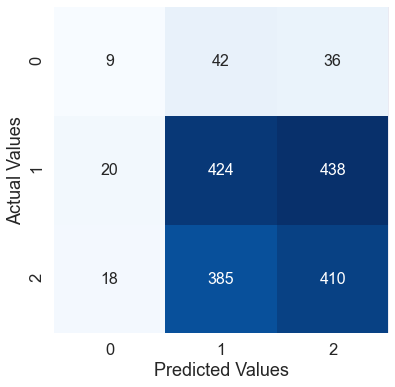

In [17]:
tic = datetime.now()

compile_train(CNN_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = CNN_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(CNN_model,X_test_scalled, Y_test_modif))

## 1. Vanila LSTM
Selected features (non-scalled)

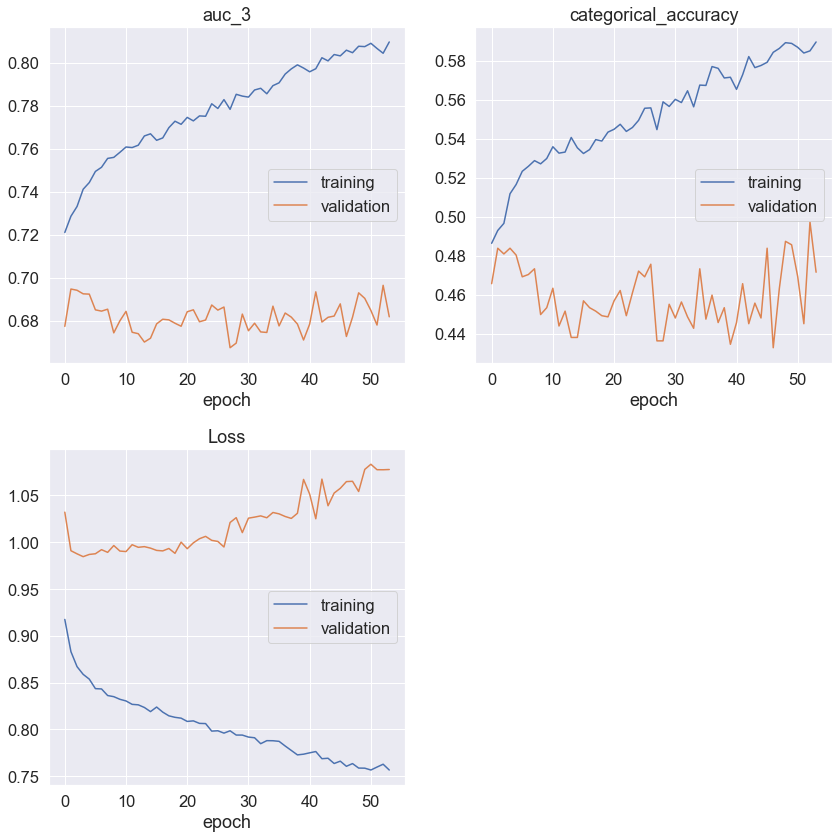

auc_3
	training         	 (min:    0.721, max:    0.810, cur:    0.810)
	validation       	 (min:    0.667, max:    0.696, cur:    0.682)
categorical_accuracy
	training         	 (min:    0.486, max:    0.590, cur:    0.590)
	validation       	 (min:    0.433, max:    0.497, cur:    0.472)
Loss
	training         	 (min:    0.757, max:    0.918, cur:    0.757)
	validation       	 (min:    0.985, max:    1.083, cur:    1.078)
5467/5467 [==============================] - 1s 195us/sample - loss: 0.7566 - categorical_accuracy: 0.5897 - auc_3: 0.8096 - val_loss: 1.0777 - val_categorical_accuracy: 0.4715 - val_auc_3: 0.6818
Training time:0:00:59.452330
1782/1782 [==============================] - 0s 68us/sample - loss: 0.8926 - categorical_accuracy: 0.4933 - auc_3: 0.7274
Accuracy on Test set: 49.33%
|vanilaLSTM|
 Error rate = 0.5067340067340067 
 MSE =  0.6060606060606061 
 Accuracy =  0.49326599326599324 
 AUC =  0.5308678629337621 
 F1-score =  0.3426073000180843 
 Fbeta =  0.3500117778129

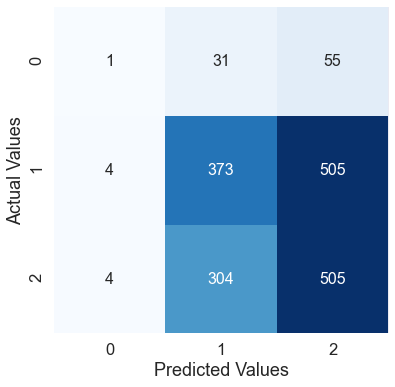

In [18]:
tic = datetime.now()

compile_train(vanilaLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model,X_test, Y_test_modif))


Selected features (scalled)

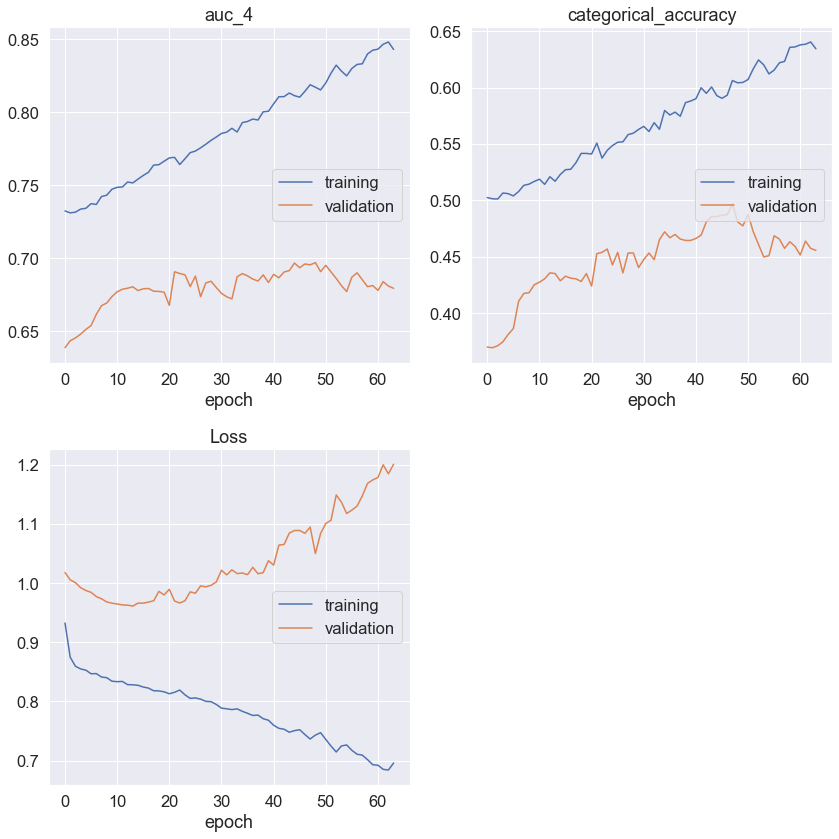

auc_4
	training         	 (min:    0.731, max:    0.848, cur:    0.843)
	validation       	 (min:    0.639, max:    0.697, cur:    0.679)
categorical_accuracy
	training         	 (min:    0.501, max:    0.640, cur:    0.634)
	validation       	 (min:    0.369, max:    0.497, cur:    0.456)
Loss
	training         	 (min:    0.684, max:    0.932, cur:    0.696)
	validation       	 (min:    0.961, max:    1.201, cur:    1.201)
5467/5467 [==============================] - 1s 192us/sample - loss: 0.6959 - categorical_accuracy: 0.6344 - auc_4: 0.8432 - val_loss: 1.2007 - val_categorical_accuracy: 0.4557 - val_auc_4: 0.6793
Training time:0:01:10.627927
1782/1782 [==============================] - 0s 73us/sample - loss: 1.0490 - categorical_accuracy: 0.4428 - auc_4: 0.6869
Accuracy on Test set: 44.28%
|vanilaLSTM|
 Error rate = 0.5572390572390572 
 MSE =  0.6683501683501684 
 Accuracy =  0.44276094276094274 
 AUC =  0.468379650726608 
 F1-score =  0.3015029660429012 
 Fbeta =  0.31525909271364

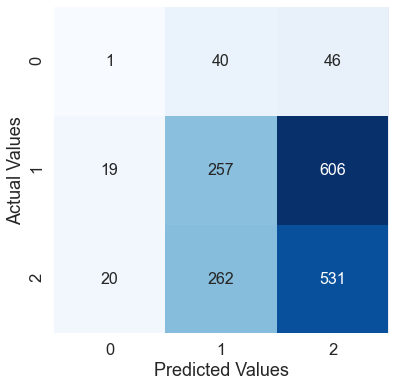

In [19]:
tic = datetime.now()

compile_train(vanilaLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model,X_test_scalled,Y_test_modif))

## 2. Stacked LSTM
Selected features (non-scalled)

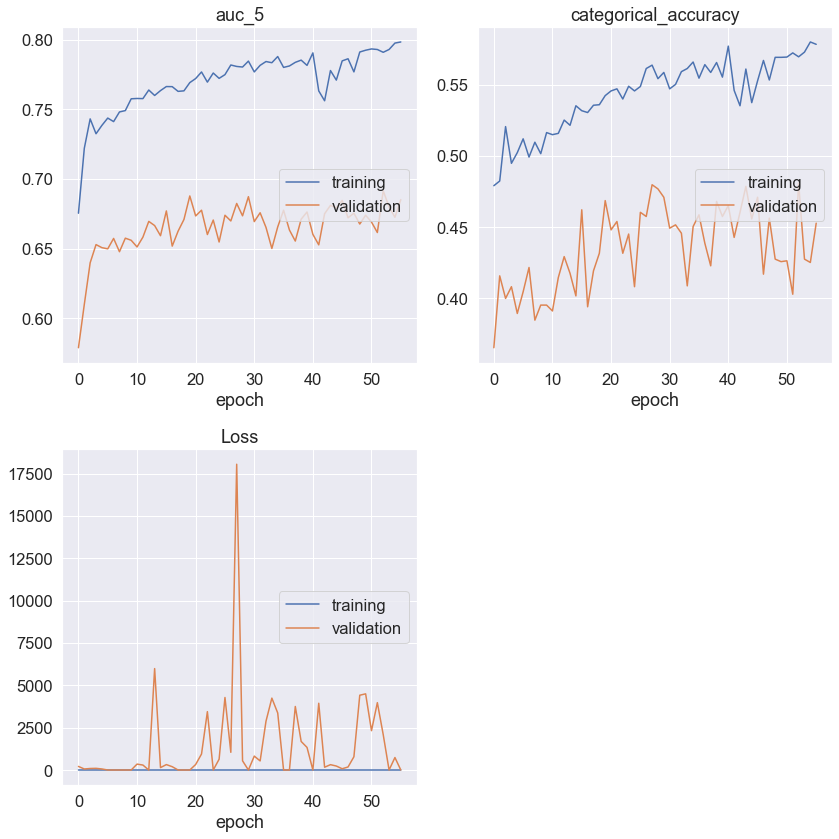

auc_5
	training         	 (min:    0.675, max:    0.798, cur:    0.798)
	validation       	 (min:    0.579, max:    0.692, cur:    0.685)
categorical_accuracy
	training         	 (min:    0.479, max:    0.580, cur:    0.578)
	validation       	 (min:    0.365, max:    0.481, cur:    0.453)
Loss
	training         	 (min:    0.768, max:    2.522, cur:    0.774)
	validation       	 (min:    0.981, max: 18049.089, cur:    1.073)
5467/5467 [==============================] - 4s 674us/sample - loss: 0.7737 - categorical_accuracy: 0.5784 - auc_5: 0.7985 - val_loss: 1.0729 - val_categorical_accuracy: 0.4527 - val_auc_5: 0.6851
Training time:0:03:09.515250
1782/1782 [==============================] - 0s 178us/sample - loss: 0.9499 - categorical_accuracy: 0.4899 - auc_5: 0.7180
Accuracy on Test set: 48.99%
|stackedLSTM|
 Error rate = 0.51010101010101 
 MSE =  0.601010101010101 
 Accuracy =  0.4898989898989899 
 AUC =  0.5141904692032083 
 F1-score =  0.3349634891721653 
 Fbeta =  0.34238817708271

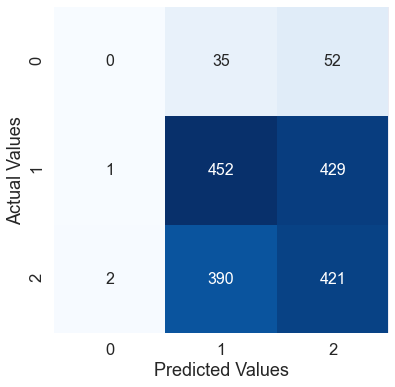

In [20]:
tic = datetime.now()

compile_train(stackedLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model,X_test, Y_test_modif))

Selected features (scalled)

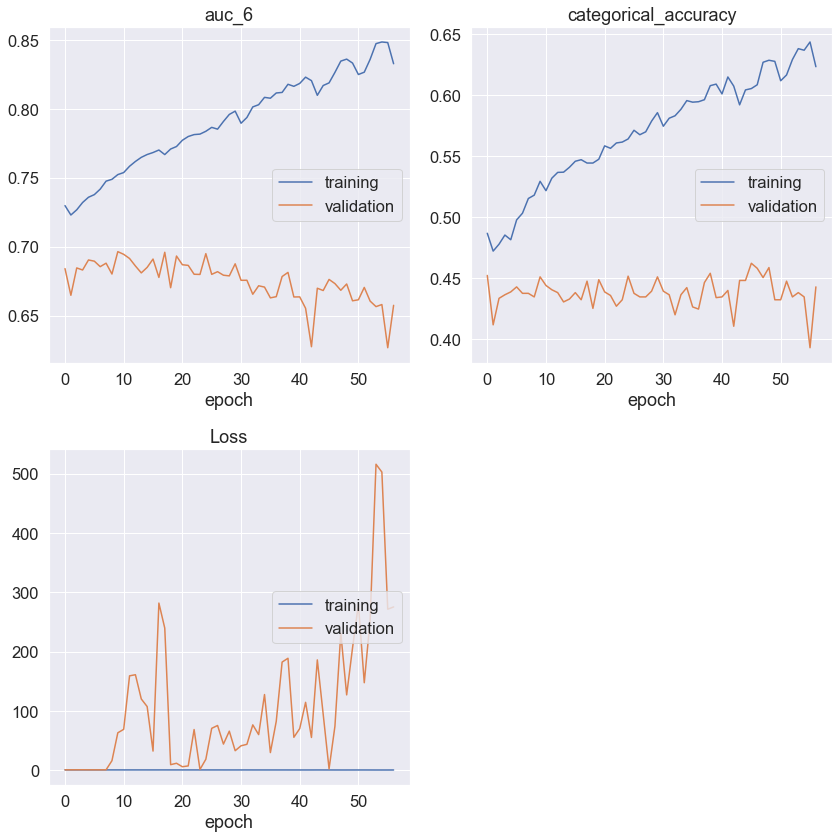

auc_6
	training         	 (min:    0.723, max:    0.849, cur:    0.833)
	validation       	 (min:    0.627, max:    0.697, cur:    0.658)
categorical_accuracy
	training         	 (min:    0.472, max:    0.644, cur:    0.623)
	validation       	 (min:    0.393, max:    0.462, cur:    0.443)
Loss
	training         	 (min:    0.678, max:    0.870, cur:    0.720)
	validation       	 (min:    0.956, max:  515.924, cur:  275.506)
5467/5467 [==============================] - 4s 663us/sample - loss: 0.7203 - categorical_accuracy: 0.6234 - auc_6: 0.8328 - val_loss: 275.5061 - val_categorical_accuracy: 0.4427 - val_auc_6: 0.6577
Training time:0:03:27.622308
1782/1782 [==============================] - 0s 195us/sample - loss: 1.3318 - categorical_accuracy: 0.4433 - auc_6: 0.6845
Accuracy on Test set: 44.33%
|stackedLSTM|
 Error rate = 0.5566778900112234 
 MSE =  0.6358024691358025 
 Accuracy =  0.44332210998877664 
 AUC =  0.4657740315656628 
 F1-score =  0.3100303837338687 
 Fbeta =  0.322726936

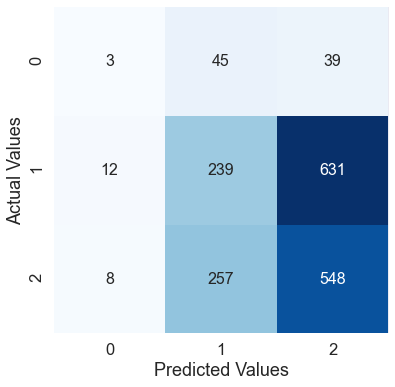

In [21]:
tic = datetime.now()

compile_train(stackedLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model,X_test_scalled,Y_test_modif))

## 3. biLSTM
Selected features (non-scalled)

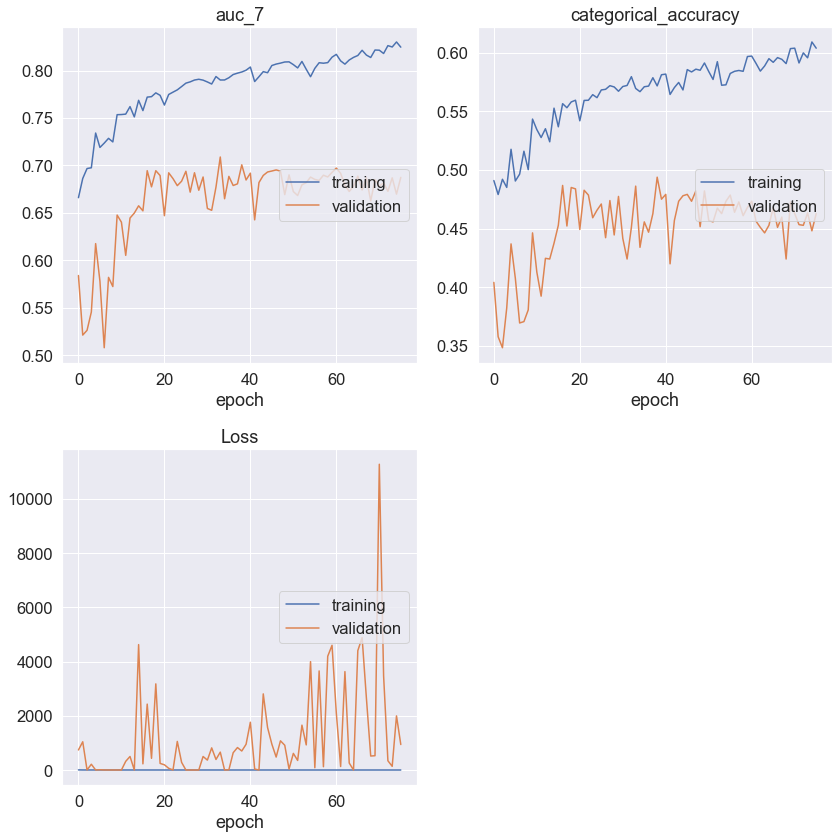

auc_7
	training         	 (min:    0.666, max:    0.830, cur:    0.825)
	validation       	 (min:    0.508, max:    0.709, cur:    0.687)
categorical_accuracy
	training         	 (min:    0.479, max:    0.609, cur:    0.604)
	validation       	 (min:    0.348, max:    0.494, cur:    0.463)
Loss
	training         	 (min:    0.709, max:    4.866, cur:    0.720)
	validation       	 (min:    1.004, max: 11280.927, cur:  940.931)
5467/5467 [==============================] - 3s 607us/sample - loss: 0.7200 - categorical_accuracy: 0.6040 - auc_7: 0.8246 - val_loss: 940.9311 - val_categorical_accuracy: 0.4627 - val_auc_7: 0.6874
Training time:0:04:24.660213
1782/1782 [==============================] - 0s 172us/sample - loss: 1.1886 - categorical_accuracy: 0.4776 - auc_7: 0.7183
Accuracy on Test set: 47.76%
|biLSTM|
 Error rate = 0.5224466891133558 
 MSE =  0.6049382716049383 
 Accuracy =  0.4775533108866442 
 AUC =  0.5032280997285535 
 F1-score =  0.3305572167727448 
 Fbeta =  0.33920709559492

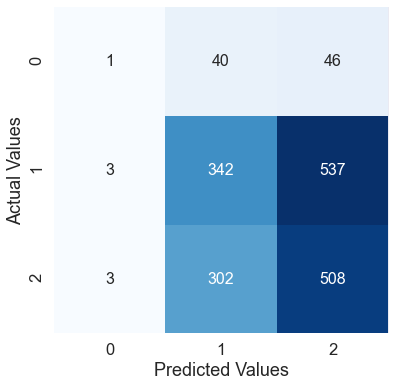

In [22]:
tic = datetime.now()

compile_train(biLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model,X_test, Y_test_modif))

Selected features (scalled)

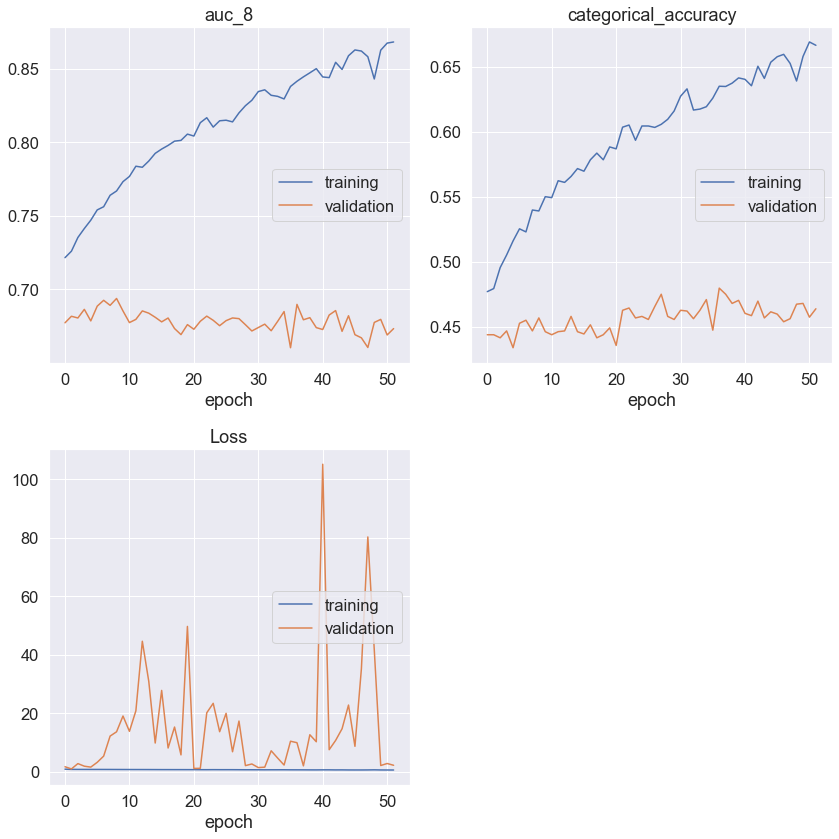

auc_8
	training         	 (min:    0.722, max:    0.868, cur:    0.868)
	validation       	 (min:    0.660, max:    0.694, cur:    0.673)
categorical_accuracy
	training         	 (min:    0.477, max:    0.669, cur:    0.666)
	validation       	 (min:    0.434, max:    0.480, cur:    0.464)
Loss
	training         	 (min:    0.636, max:    0.926, cur:    0.636)
	validation       	 (min:    1.009, max:  105.149, cur:    2.254)
5467/5467 [==============================] - 3s 637us/sample - loss: 0.6355 - categorical_accuracy: 0.6664 - auc_8: 0.8683 - val_loss: 2.2545 - val_categorical_accuracy: 0.4639 - val_auc_8: 0.6734
Training time:0:03:02.709860
1782/1782 [==============================] - 0s 172us/sample - loss: 1.4509 - categorical_accuracy: 0.4921 - auc_8: 0.7048
Accuracy on Test set: 49.21%
|biLSTM|
 Error rate = 0.5078563411896745 
 MSE =  0.5852974186307519 
 Accuracy =  0.49214365881032546 
 AUC =  0.5210231726692138 
 F1-score =  0.3646483816163249 
 Fbeta =  0.3627355421770904

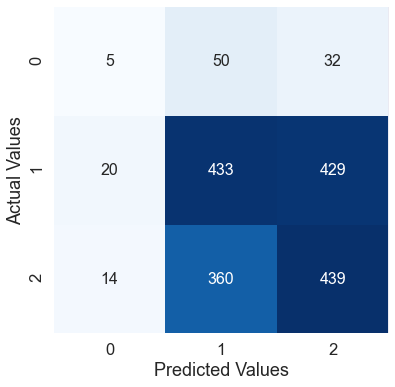

In [23]:
tic = datetime.now()

compile_train(biLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model,X_test_scalled,Y_test_modif))

## 4. BiLSTM Ensamble
Selected features (scalled)

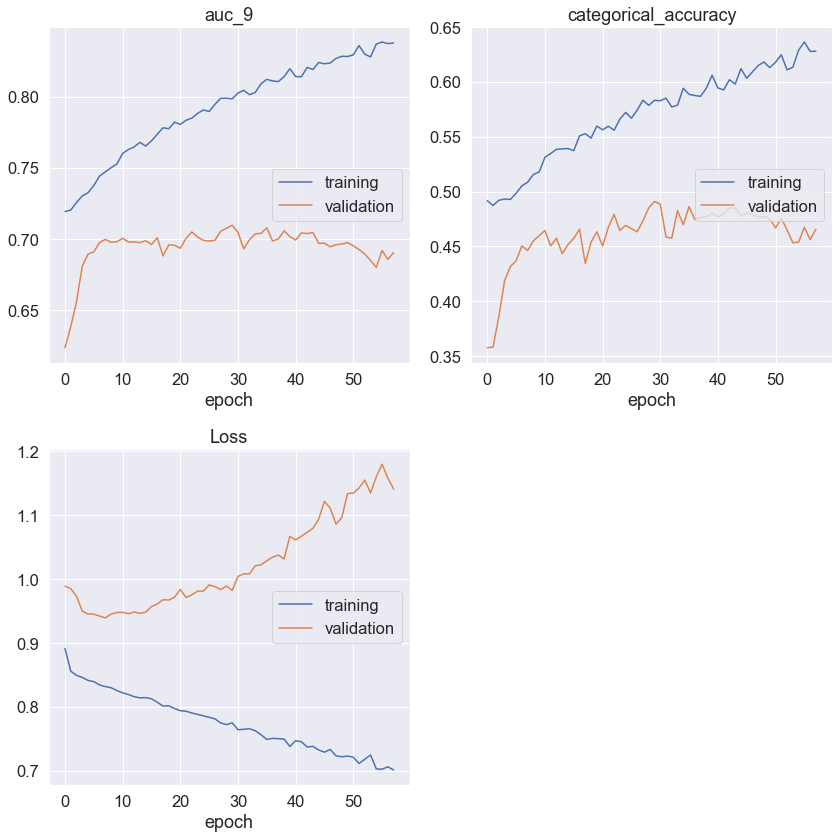

auc_9
	training         	 (min:    0.719, max:    0.839, cur:    0.838)
	validation       	 (min:    0.623, max:    0.710, cur:    0.690)
categorical_accuracy
	training         	 (min:    0.487, max:    0.636, cur:    0.628)
	validation       	 (min:    0.358, max:    0.491, cur:    0.466)
Loss
	training         	 (min:    0.701, max:    0.891, cur:    0.701)
	validation       	 (min:    0.939, max:    1.180, cur:    1.141)
5467/5467 [==============================] - 2s 295us/sample - loss: 0.7012 - categorical_accuracy: 0.6279 - auc_9: 0.8379 - val_loss: 1.1410 - val_categorical_accuracy: 0.4656 - val_auc_9: 0.6904
Training time:0:01:35.805656
1782/1782 [==============================] - 0s 95us/sample - loss: 1.0536 - categorical_accuracy: 0.4736 - auc_9: 0.7056
Accuracy on Test set: 47.36%
|biLSTM_en|
 Error rate = 0.5263748597081931 
 MSE =  0.6071829405162739 
 Accuracy =  0.47362514029180697 
 AUC =  0.5598492047107049 
 F1-score =  0.34267870870852896 
 Fbeta =  0.3476165599426

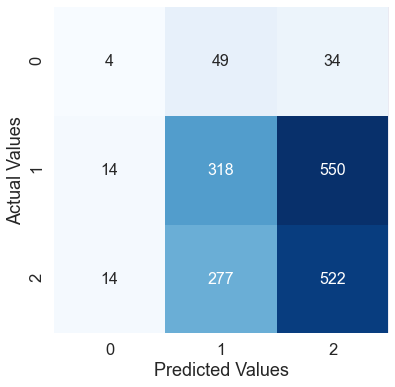

In [24]:
tic = datetime.now()

compile_train(biLSTM_en_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model,X_test_scalled,Y_test_modif))

Selected features (non-scalled)

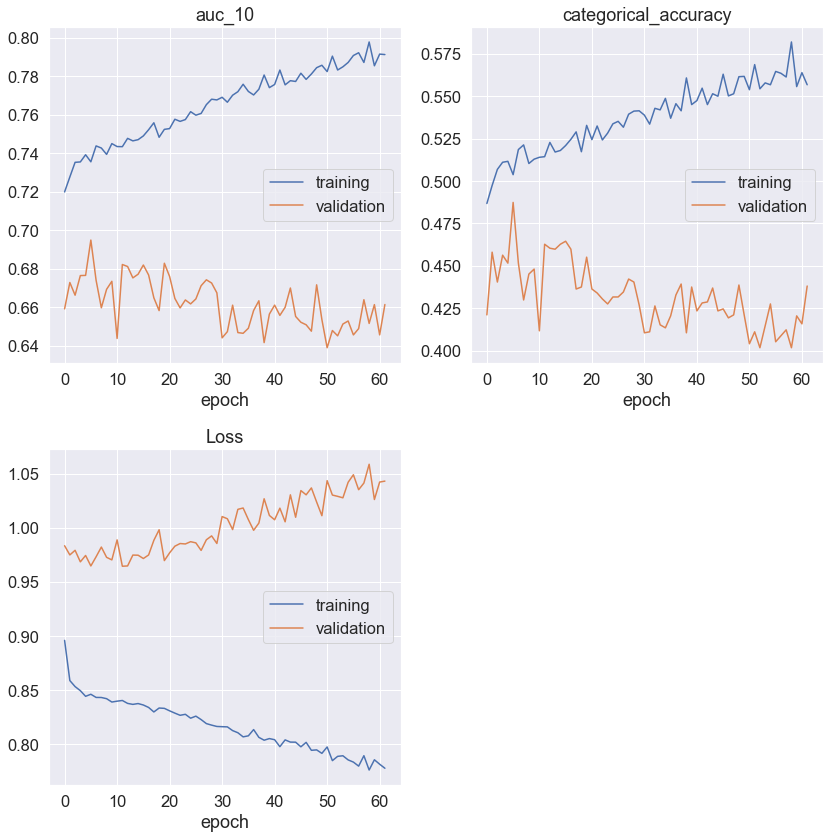

auc_10
	training         	 (min:    0.720, max:    0.798, cur:    0.791)
	validation       	 (min:    0.639, max:    0.695, cur:    0.661)
categorical_accuracy
	training         	 (min:    0.487, max:    0.582, cur:    0.557)
	validation       	 (min:    0.402, max:    0.487, cur:    0.438)
Loss
	training         	 (min:    0.776, max:    0.896, cur:    0.778)
	validation       	 (min:    0.965, max:    1.059, cur:    1.043)
5467/5467 [==============================] - 2s 284us/sample - loss: 0.7778 - categorical_accuracy: 0.5568 - auc_10: 0.7912 - val_loss: 1.0433 - val_categorical_accuracy: 0.4381 - val_auc_10: 0.6615
Training time:0:01:39.136201
1782/1782 [==============================] - 0s 93us/sample - loss: 0.8781 - categorical_accuracy: 0.5051 - auc_10: 0.7307
Accuracy on Test set: 50.51%
|biLSTM_en|
 Error rate = 0.494949494949495 
 MSE =  0.5656565656565656 
 Accuracy =  0.5050505050505051 
 AUC =  0.543960019937722 
 F1-score =  0.3443720204697212 
 Fbeta =  0.3542292427011

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


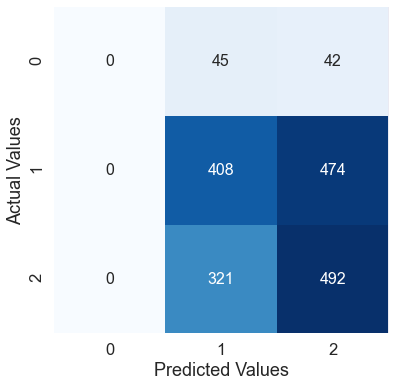

In [25]:
tic = datetime.now()

compile_train(biLSTM_en_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_en_model,X_test, Y_test_modif))